In [1]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



# Generate Simulated Data Set

In [2]:
library(tidyverse)
library(caret)

In [3]:
## Functions used to generate fake data
set.seed(42)
f_fried <- function(x) 10 * sin(pi * x[,1] * x[,2]) + 20 * (x[,3] - 0.5)^2 + 
  10 * x[,4] + 5 * x[,5]

our_function <- function(x) sin(x[,1])*exp(x[,2])*10 + cos(2*x[,3]) - 20*x[,4]^2 + 3*x[,5]^3 - 15*x[,6]^(1/3) 

high_dimensional_func <- function(x) 10 * sin(pi * apply(x[,1:200], 1, prod)) + 20 * (apply(x[,201:300],1,sum) - 5)^2 + 
  10 * apply(x[,301:400],1,sum) + 5 * apply(x[,401:500],1,sum)

gen_data <- function(n_train, n_test, func, P, sigma, a, b) {
  X <- matrix(runif(n_train * P, a, b), nrow = n_train)
  mu <- func(X)
  X_test <- matrix(runif(n_test * P, a, b), nrow = n_test)
  mu_test <- func(X_test)
  Y <- mu + sigma * rnorm(n_train)
  Y_test <- mu_test + sigma * rnorm(n_test)
  
  return(list(X = X, Y = Y, mu = mu, X_test = X_test, Y_test = Y_test, mu_test = mu_test))
}

set.seed(42)
# only 5 predictors are important out of 500, and p > n
sim_data_high_dim_sparse <- gen_data(250, 100, f_fried, 500, 1, 0, 1)
sim_data <- sim_data_high_dim_sparse

In [4]:
sim_data$X %>% head
sim_data$Y %>% head

0.9148060,0.33423133,0.1365052,0.24492099,0.84829322,0.73592037,0.05391100,0.1651787,0.9899656,0.24640458,⋯,0.99427294,0.7423870,0.72410687,0.16582872,0.2326665,0.4323665,0.88768936,0.2056952,0.7571951,0.28780657
0.9370754,0.18843433,0.1771364,0.08763591,0.06274633,0.75178575,0.95509577,0.7277811,0.4384936,0.02302811,⋯,0.06966940,0.9547126,0.49973936,0.37820132,0.3646830,0.8549922,0.44734078,0.7106295,0.1809865,0.26822268
0.2861395,0.26971618,0.5195605,0.39110850,0.81984509,0.33261448,0.02560094,0.2061579,0.6999032,0.28421418,⋯,0.04320362,0.6666864,0.43107205,0.09545684,0.8591651,0.8267867,0.07004356,0.9331143,0.1791534,0.88956639
0.8304476,0.53074408,0.8111208,0.18256143,0.53936029,0.05754862,0.92076314,0.5864655,0.8890770,0.81289268,⋯,0.27283225,0.2487890,0.02452249,0.09963018,0.6486600,0.5641049,0.20832449,0.2310083,0.2310819,0.03190875
0.6417455,0.02145023,0.1153620,0.13362478,0.49902010,0.67441545,0.36666474,0.9135460,0.8341595,0.71891839,⋯,0.64295571,0.2757056,0.18624315,0.76918417,0.7825161,0.5704042,0.10296584,0.6558101,0.8031555,0.08497604
0.5190959,0.79876031,0.8934218,0.25746291,0.02222732,0.04157017,0.69839255,0.2069666,0.7344215,0.52957674,⋯,0.82524866,0.4466356,0.61867453,0.60448438,0.8199726,0.3800179,0.22248305,0.9631550,0.2135561,0.98446287


[1] 17.429742  8.711487  9.976158 16.668583  7.449817 14.430912

# BART with 500 Predictors, 5 important

In [6]:
options(java.parameters = "-Xmx8g")
library(bartMachine)

Loading required package: rJava
Loading required package: bartMachineJARs
Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.3! You have 7.64GB memory available.

If you run out of memory, restart R, and use e.g.
'options(java.parameters = "-Xmx5g")' for 5GB of RAM b

In [7]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [8]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [9]:
t.start <- Sys.time()
sim.bm <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 501 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 3.48835 secs


In [10]:
k_fold_cv(X = sim_data$X %>% data.frame, y = sim_data$Y,)

.....


$y_hat
  [1] 14.757441  8.106139 13.449141 14.118828 10.355534 12.869890 13.687291
  [8] 12.364401 19.014572 21.048995 19.937145 14.392262 11.188324  8.521795
 [15] 16.475044 15.464855 19.563709  8.547521 16.182157 15.788091 13.185051
 [22]  8.327111 14.360057 10.028885 13.470886  8.915421 16.497474 17.055015
 [29] 17.775083 20.710944 19.279067 12.685940 10.669177 11.118857 12.876103
 [36] 12.385183 12.167661 10.511205 14.688970  7.387358 19.177965 14.597290
 [43] 11.961349 11.985886 14.579225  9.026746 17.359130 13.260987 16.355976
 [50]  7.132327 18.588610 17.712834  7.197608 17.103835 13.421888 14.991904
 [57] 17.876647  9.625787  9.628613 13.519317  7.775110 21.876892 15.891055
 [64] 11.223507 15.359804 15.641532 17.469720 12.432689 11.841356 16.102444
 [71]  9.863924 13.000584 10.202989 10.477062  8.274203 21.010876  9.824334
 [78] 10.319785 12.488999  7.083765 13.558594 10.678191  6.093351 16.276295
 [85] 17.240500 14.748672 13.844284 14.602736 16.727878  6.718656 20.507328
 [92] 10.400880 10.315838 16.663468 12.355812  8.443719 14.129138 12.235522
 [99] 20.626079 13.881247 14.129291 18.001607  7.638925 10.146887 16.859187
[106] 12.531325 18.044235 19.971862 16.828918 18.278666 19.290592 18.431402
[113] 13.844640 13.513268 14.545727 17.131641 11.357730 11.305788 14.202931
[120] 15.715825 13.917098 17.789177 12.515463 13.809416 18.303353 17.656877
[127]  9.893709 14.115937 11.549564 17.326953 17.441860 19.535730 17.723919
[134] 16.077964 19.574642 13.513744  9.199438  8.600220 16.762465 15.224491
[141] 10.512885 14.472671 17.863239 12.989262 14.053369 18.866428  9.856265
[148] 13.428598 17.301334 10.208007  9.658985 12.061860 17.084463 12.816805
[155] 18.154324 16.531663 12.950139  9.753742  9.786244 10.606618 11.821086
[162] 14.071938 15.378331 17.201396 14.166257 11.669847 14.088559 15.623001
[169] 10.941768  5.326258 12.226421 19.733007 20.331341 13.666313 14.779444
[176]  9.819385 13.104385 15.028958 12.556190 15.639539 16.019569 18.249399
[183] 16.732773 12.116884 20.909021 10.205300 12.860412 12.242054  5.651161
[190] 16.758073 12.885708 18.546629  8.536741 10.087376 15.485063 12.628506
[197]  6.723999 14.399940 19.592500  8.357477 15.409918 15.645436 15.233828
[204] 16.674780 12.382894 15.704403 15.831930 18.551829 14.743533 15.565621
[211] 17.789771 16.399070  8.359717 10.473081  7.441236 20.077564  8.510757
[218]  7.530675 17.620836 15.311997 13.888023  8.292157 19.389896 17.290720
[225] 11.702675 14.492391 13.236143 10.496736 11.864487 10.600229 12.021132
[232]  8.803657 15.009576 14.401194 19.112564 15.472511 15.813864 12.959864
[239]  9.448636 12.854737 17.244387 13.228437 17.617188 18.307135 13.048679
[246] 11.686633 14.616174  9.387863 11.982019  9.386737

$L1_err
[1] 504.2259

$L2_err
[1] 1599.761

$rmse
[1] 2.529633

$PseudoRsq
[1] 0.7480135

$folds
  [1] 3 4 2 4 5 2 1 3 2 4 4 4 5 1 1 2 5 1 3 1 1 4 2 4 3 3 2 2 4 4 2 5 3 5 3 5 5
 [38] 3 1 5 1 1 1 2 1 5 4 1 4 5 4 3 3 2 3 4 4 3 2 1 5 2 2 4 4 5 5 5 4 4 1 3 5 3
 [75] 1 3 4 5 2 1 1 4 4 1 4 5 1 1 3 5 4 3 1 2 4 2 2 1 3 3 4 3 5 3 2 2 3 3 2 3 2
[112] 2 5 1 2 2 2 1 1 2 3 5 1 5 3 3 3 5 2 5 4 5 4 3 4 3 4 1 4 4 4 1 4 4 2 2 5 5
[149] 2 4 4 4 3 5 5 2 1 3 1 2 3 5 2 3 4 3 4 3 2 3 2 1 1 5 1 2 1 2 4 3 2 2 5 1 2
[186] 4 1 4 5 4 3 1 1 1 2 2 3 5 3 5 1 1 5 5 5 5 1 4 3 3 5 1 2 3 4 1 2 1 5 3 5 3
[223] 2 2 1 4 5 4 5 3 4 1 5 3 4 5 2 1 3 5 2 1 2 4 3 5 1 2 5 5

In [11]:
sim.bm %>% summary

bartMachine v1.2.3 for regression

training data n = 250 and p = 500 
built in 2.7 secs on 16 cores, 50 trees, 250 burn-in and 1000 post. samples

sigsq est for y beforehand: 25.496 
avg sigsq estimate after burn-in: 3.43306 

in-sample statistics:
 L1 = 205.95 
 L2 = 257.63 
 rmse = 1.02 
 Pseudo-Rsq = 0.9594
p-val for shapiro-wilk test of normality of residuals: 0.47135 
p-val for zero-mean noise: 0.56748 



In [12]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [13]:
rmse(sim_data$Y, predict(sim.bm, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.bm, sim_data$X_test %>% data.frame)) #out of sample

[1] 1.015143

[1] 2.293146

In [14]:
sim.bm %>% check_bart_error_assumptions

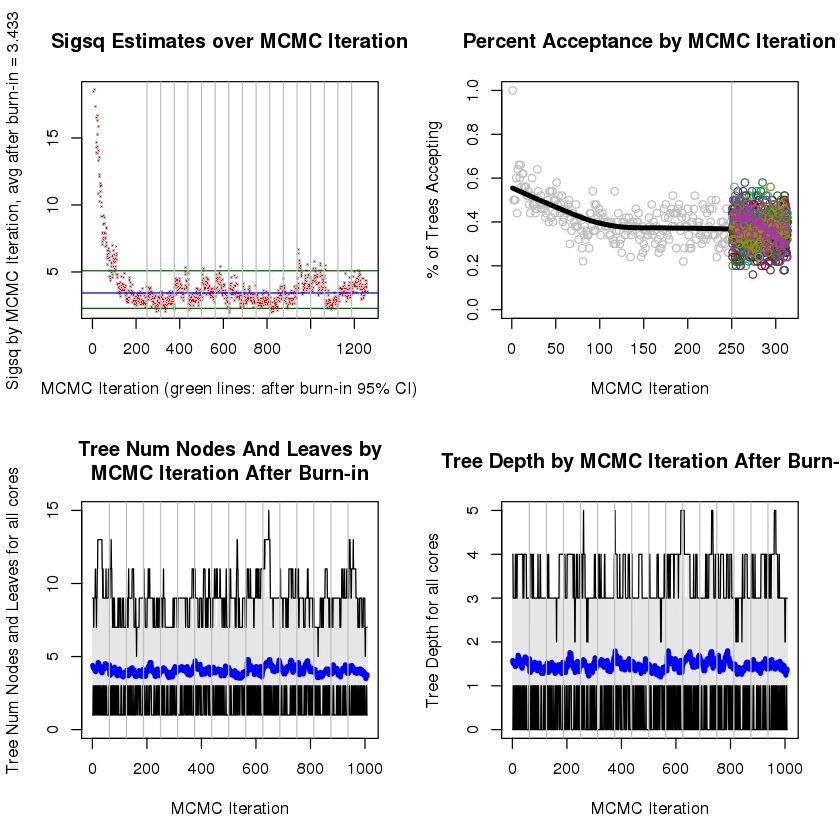

In [15]:
sim.bm %>% plot_convergence_diagnostics

....................


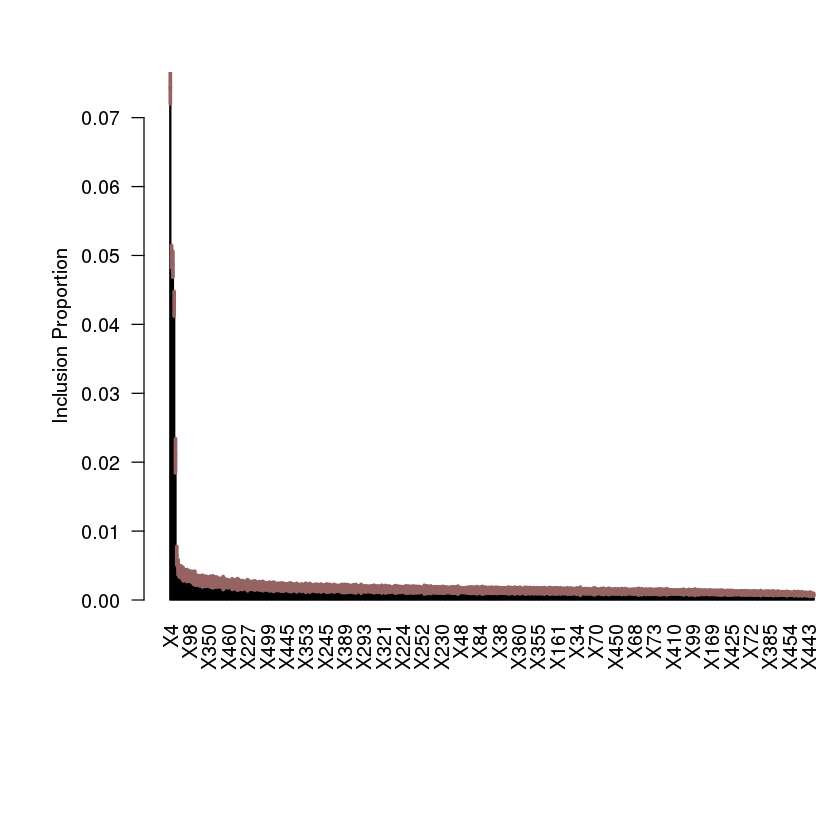

In [16]:
investigate_var_importance(sim.bm, num_replicates_for_avg = 20)

In [17]:
saveRDS(sim.bm,"model_files/simbm_highdim_sparse_model_v1_20191124.RDS")
sim.bm.read <- readRDS("model_files/simbm_highdim_sparse_model_v1_20191124.RDS")
sim.bm <- sim.bm.read

# DART with 20 Predictors, 5 important

In [5]:
options(java.parameters = "-Xmx8g")
library(dartMachine)

Loading required package: rJava
Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.0! You have 7.64GB memory available.



In [6]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [7]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [8]:
t.start <- Sys.time()
sim.dartmachine <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
Now building bartMachine for regression ...Covariate importance prior ON. 
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 17.50957 secs


In [10]:
sim.dartmachine %>% summary

bartMachine v1.2.0 for regression

training data n = 250 and p = 500 
built in 15.1 secs on 16 cores, 50 trees, 4000 burn-in and 4000 post. samples

sigsq est for y beforehand: 25.496 
avg sigsq estimate after burn-in: 1.71264 

in-sample statistics:
 L1 = 130.39 
 L2 = 108.45 
 rmse = 0.66 
 Pseudo-Rsq = 0.9829
p-val for shapiro-wilk test of normality of residuals: 0.12173 
p-val for zero-mean noise: 0.31982 



In [11]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [12]:
rmse(sim_data$Y, predict(sim.dartmachine, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.dartmachine, sim_data$X_test %>% data.frame)) #out of sample

[1] 0.6586455

[1] 2.109708

In [13]:
sim.dartmachine %>% check_bart_error_assumptions

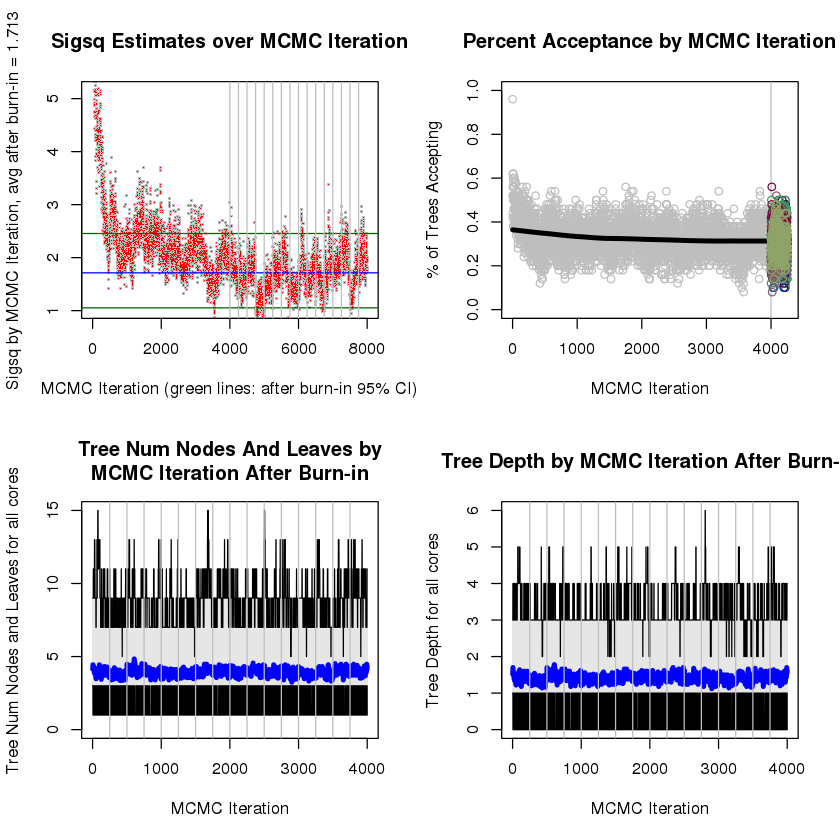

In [14]:
sim.dartmachine %>% plot_convergence_diagnostics

....................


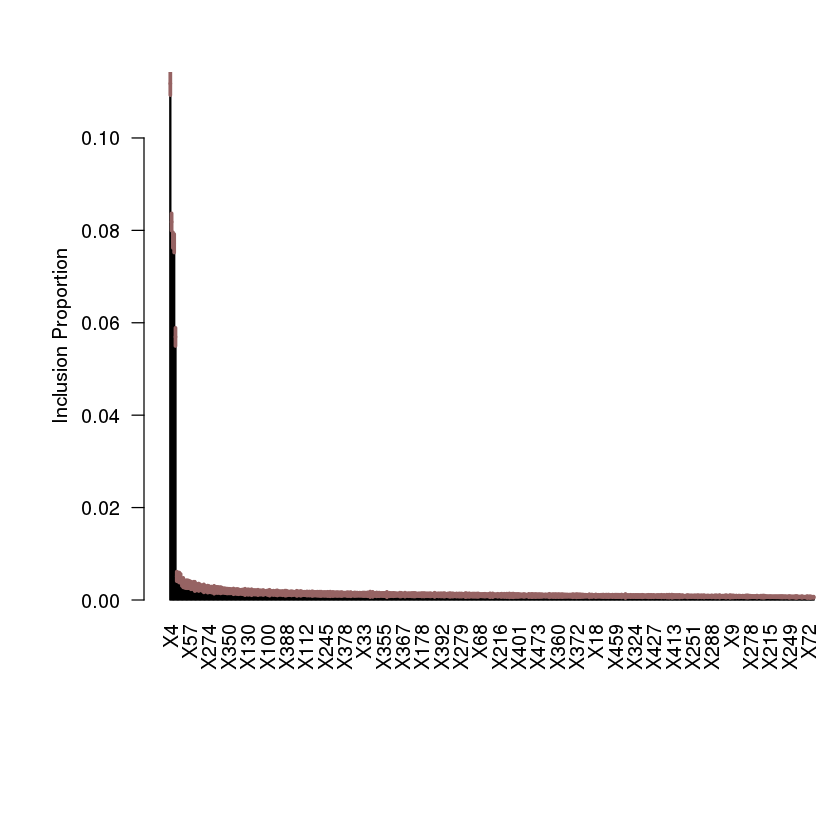

In [15]:
investigate_var_importance(sim.dartmachine, num_replicates_for_avg = 20)

In [16]:
saveRDS(sim.dartmachine,"model_files/simdartMachine_highdim_sparse_model_v1_20191124.RDS")
sim.dartmachine.read <- readRDS("model_files/simdartMachine_highdim_sparse_model_v1_20191124.RDS")
sim.dartmachine <- sim.dartmachine.read

# SoftBART with 20 Predictors, 5 important

In [17]:
library(SoftBart)

Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: glmnet
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 3.0-1

Loading required package: Rcpp


Finishing warmup 100 Number of trees = 50
Finishing warmup 200 Number of trees = 50
Finishing warmup 300 Number of trees = 50
Finishing warmup 400 Number of trees = 50
Finishing warmup 500 Number of trees = 50
Finishing warmup 600 Number of trees = 50
Finishing warmup 700 Number of trees = 50
Finishing warmup 800 Number of trees = 50
Finishing warmup 900 Number of trees = 50
Finishing warmup 1000 Number of trees = 50
Finishing warmup 1100 Number of trees = 50
Finishing warmup 1200 Number of trees = 50
Finishing warmup 1300 Number of trees = 50
Finishing warmup 1400 Number of trees = 50
Finishing warmup 1500 Number of trees = 50
Finishing warmup 1600 Number of trees = 50
Finishing warmup 1700 Number of trees = 50
Finishing warmup 1800 Number of trees = 50
Finishing warmup 1900 Number of trees = 50
Finishing warmup 2000 Number of trees = 50
Finishing warmup 2100 Number of trees = 50
Finishing warmup 2200 Number of trees = 50
Finishing warmup 2300 Number of trees = 50
Finishing warmup 240

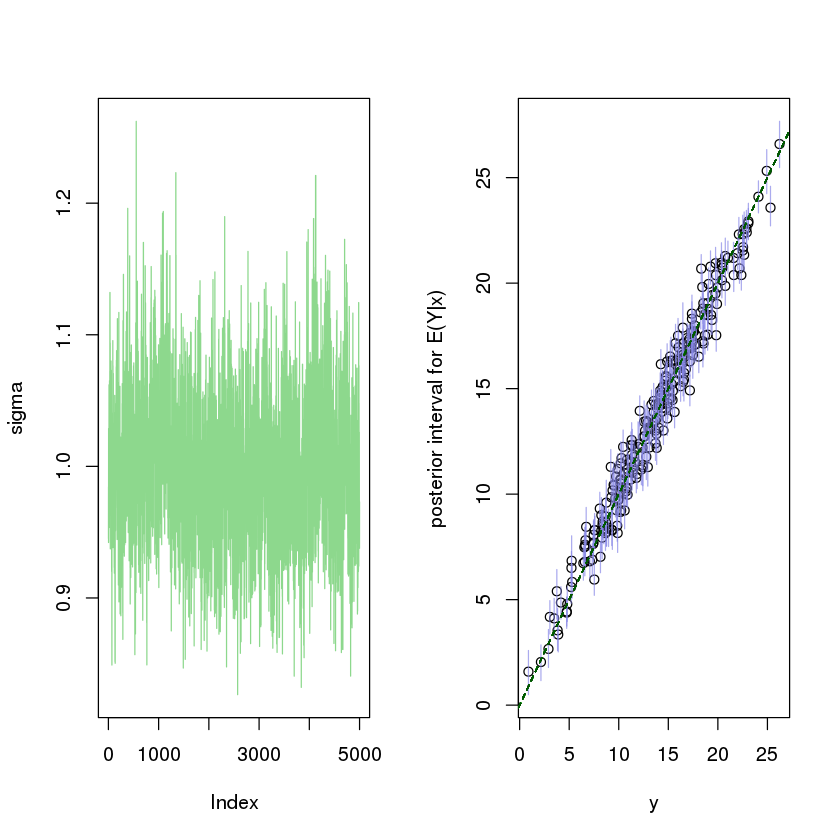

In [18]:
## Fit the models
softbart_fit_1 <- softbart(X = sim_data$X, Y = sim_data$Y, X_test = sim_data$X_test, 
                hypers = Hypers(sim_data$X, sim_data$Y, num_tree = 50, temperature = 1),
                opts = Opts(num_burn = 5000, num_save = 5000, update_tau = TRUE))

plot(softbart_fit_1)

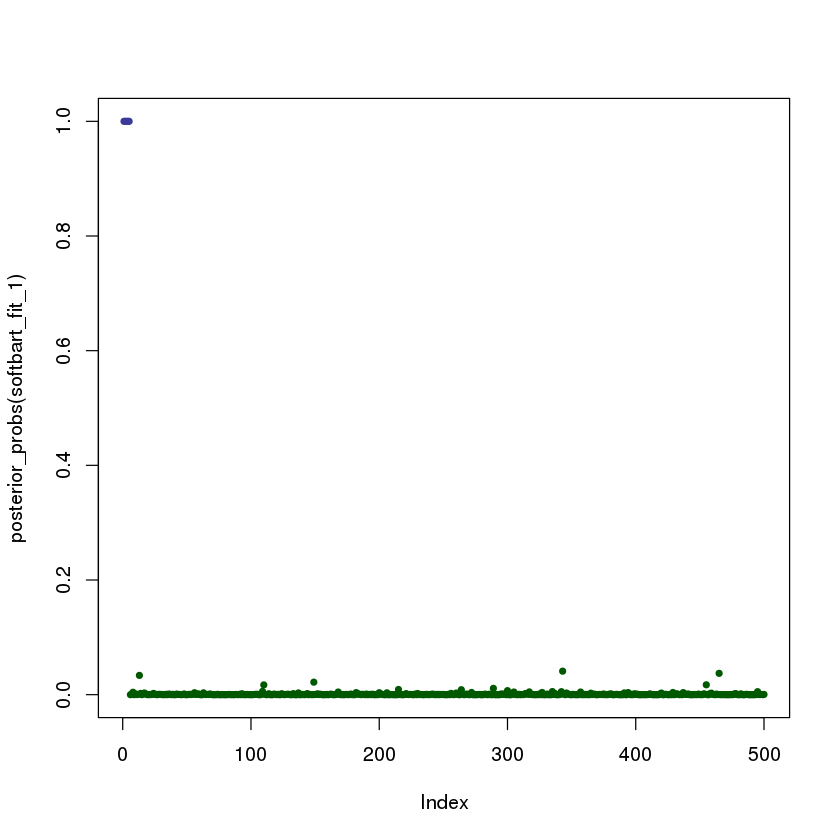

In [19]:
## Look at posterior model inclusion probabilities for each predictor. 

posterior_probs <- function(fit) colMeans(fit$var_counts > 0)
plot(posterior_probs(softbart_fit_1), 
     col = ifelse(posterior_probs(softbart_fit_1) > 0.5, muted("blue"), muted("green")), 
     pch = 20)

rmse <- function(x,y) sqrt(mean((x-y)^2))

In [20]:
rmse(softbart_fit_1$y_hat_train_mean, sim_data$Y)
rmse(softbart_fit_1$y_hat_test_mean, sim_data$Y_test)

[1] 0.8524885

[1] 1.129363

In [21]:
saveRDS(softbart_fit_1,file = "model_files/softbart_highdim_sparse_model_20191124.RDS")

In [22]:
softbart_fit_1.read = readRDS("model_files/softbart_highdim_sparse_model_20191124.RDS")
softbart_fit_1 <- softbart_fit_1.read